## 📊 Simulación

🧑‍💻 Lucía Cordero | Jorge Garcelán

![Election Results](https://elordenmundial.com/wp-content/uploads/2020/10/editable-portada-especial-.png)


<div class="warning" style='padding:0.1em; border-left: 4px solid #17a2b8; background-color:#e8f8ff;'>
<span>
<p style='margin-top:1em; margin-left:1em; text-align:left'>
<b>💡Interpretación de la simulación</b></p>
<p style='margin-left:1em;'>
Imaginemos que estamos en el día de las elecciones y nos van llegando datos de condados (equivalentes a dataset de train) y queremos hacer un forecast de cómo van a acabar las elecciones, es decir, hacer un forecast de los condados que todavía no tenemos los datos (test). En ese sentido, podríamos hacer un modelo con los datos que sí tenemos (train) y predecir los condados que todavía no tenemos (test). Y así podemos repetir el proceso N veces y crear una simulación.
</p>
</span>
</div>

## Libraries

In [154]:
import pandas as pd
from pandas import read_csv
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import json
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

## Load data

In [155]:
CENSUS_YEAR = 2023
ELECTORAL_YEAR = CENSUS_YEAR + 1


In [156]:
def load_seats_data(path, state_to_code):
    # Cargar datos
    seats_data = pd.read_csv(path, header=0, sep=",")

    # Seleccionar las primeras tres columnas y las columnas que contienen "2019"
    seats_data = seats_data.iloc[:, [0, 1]]

    # Renombrar columnas
    seats_data.columns = ["state", "electoral_votes_number"]

    # Añadir District of Columbia pues no aparece
    new_row = pd.DataFrame({
        'state': ['District of Columbia'],
        'electoral_votes_number': [3]
    })

    # Añadir la nueva fila al DataFrame utilizando pd.concat
    seats_data = pd.concat([seats_data, new_row], ignore_index=True)

    
    seats_data["state_code"] = seats_data['state'].map(state_to_code)

    return seats_data

In [157]:
# Cargar codigo de estados
with open("data/state_to_code.json", "r") as file:
    state_to_code = json.load(file)


# Cargar datos de escaños por estado
seats_data = load_seats_data(f"data/seats2020.csv", state_to_code)

# Cargar datos de state, county, fips
state_fips_county = read_csv('data/state_fips_county.csv')
state_names = state_fips_county['state']
fips_codes = state_fips_county['fips']
county_names = state_fips_county['county']

### 2016

In [158]:
# Cargar datos
data_2016 = read_csv(f"data/final_data_{2016}.csv")

In [159]:
# Cargar datos electorales reales
df_actual = pd.DataFrame({'Votes_dem': data_2016['votes_dem'], 
                            'Votes_gop': data_2016['total_votes'] - data_2016['votes_dem'] - data_2016['votes_others'], 
                            'Votes_other': data_2016['votes_others'],
                            'Votes_total': data_2016['total_votes'], 
                            'state': state_names,
                            'county': county_names,
                            'fips': fips_codes})
df_actual_state = df_actual.groupby('state').agg(Votes_dem=(f'Votes_dem', 'sum'), 
                                                    Votes_gop=(f'Votes_gop', 'sum'),
                                                    Votes_other=(f'Votes_other', 'sum'),
                                                    Votes_total=(f'Votes_total', 'sum'))

df_actual_state["Per_dem_2016"] = df_actual_state["Votes_dem"] / df_actual_state["Votes_total"]
df_actual_state["Per_gop_2016"] = df_actual_state["Votes_gop"] / df_actual_state["Votes_total"]

# Añadir la columna "Winner" basado en los porcentajes predichos de Biden y Trump
df_actual_state["Winner"] = np.where(df_actual_state["Per_dem_2016"] < df_actual_state["Per_gop_2016"], 'gop', 'dem')


full_df_actual_state = pd.merge(seats_data, df_actual_state, how='inner', on=["state"])



# Añadir diferencia entre Biden y Trump
full_df_actual_state['Difference'] = (full_df_actual_state["Per_dem_2016"] - full_df_actual_state["Per_gop_2016"]) * 100


# Definir las condiciones y los valores a asignar
conditions = [
    full_df_actual_state["Difference"] > 10,
    full_df_actual_state["Difference"].between(2.5, 10),
    full_df_actual_state["Difference"].between(-2.5, 2.5),
    full_df_actual_state["Difference"].between(-10, -2.5),
    full_df_actual_state["Difference"] < -10
]

choices = [
    "Safe Democrat",
    "Likely Democrat",
    "Toss-Up",
    "Likely Republican",
    "Safe Republican"
]

# Usar np.select para asignar el "Status" basado en las condiciones, con un valor por defecto "Unknown"
full_df_actual_state["Status"] = np.select(conditions, choices, default="Unknown")

full_df_actual_state_2016 = full_df_actual_state.copy()
full_df_actual_state_2016

,state,electoral_votes_number,state_code,Votes_dem,Votes_gop,Votes_other,Votes_total,Per_dem_2016,Per_gop_2016,Winner,Difference,Status
0,California,55,CA,7362490.0,3916209.0,675618.0,11954317.0,0.615885,0.327598,dem,28.828757,Safe Democrat
1,Texas,38,TX,3866536.0,4677007.0,370961.0,8914504.0,0.433735,0.524651,gop,-9.091599,Likely Republican
2,New York,29,NY,4097644.0,2636692.0,256359.0,6990695.0,0.586157,0.377172,dem,20.898523,Safe Democrat
3,Florida,29,FL,4411809.0,4564423.0,289694.0,9265926.0,0.476133,0.492603,gop,-1.647045,Toss-Up
4,Pennsylvania,20,PA,2519725.0,2671255.0,193198.0,5384178.0,0.467987,0.496131,gop,-2.814357,Likely Republican
5,Illinois,20,IL,2972667.0,2105089.0,277793.0,5355549.0,0.555063,0.393067,dem,16.199609,Safe Democrat
6,Ohio,18,OH,2303483.0,2740365.0,234572.0,5278420.0,0.436396,0.519164,gop,-8.276757,Likely Republican
7,Michigan,16,MI,2269595.0,2281120.0,243208.0,4793923.0,0.473432,0.475836,gop,-0.240409,Toss-Up
8,Georgia,16,GA,1877124.0,2080631.0,129671.0,4087426.0,0.459244,0.509032,gop,-4.978855,Likely Republican
9,North Carolina,15,NC,2130869.0,2291602.0,126184.0,4548655.0,0.468461,0.503798,gop,-3.533638,Likely Republican


In [160]:
# columns_to_drop = ['Total_2020', 'Other_2020', 'Winner_2020', "Biden_2020"]  # Nombres de las columnas a eliminar
columns_to_drop = ["votes_dem", "total_votes", "votes_others", "per_votes_others", "winner"]  # Nombres de las columnas a eliminar

data_2016 = data_2016.drop(columns=columns_to_drop)

### 2020

In [161]:
# Cargar datos
data_2020 = read_csv(f"data/final_data_{2020}.csv")

In [162]:
# Cargar datos electorales reales
df_actual = pd.DataFrame({'Votes_dem': data_2020['votes_dem'], 
                            'Votes_gop': data_2020['total_votes'] - data_2020['votes_dem'] - data_2020['votes_others'], 
                            'Votes_other': data_2020['votes_others'],
                            'Votes_total': data_2020['total_votes'], 
                            'state': state_names,
                            'county': county_names,
                            'fips': fips_codes})
df_actual_state = df_actual.groupby('state').agg(Votes_dem=(f'Votes_dem', 'sum'), 
                                                    Votes_gop=(f'Votes_gop', 'sum'),
                                                    Votes_other=(f'Votes_other', 'sum'),
                                                    Votes_total=(f'Votes_total', 'sum'))

df_actual_state["Per_dem_2020"] = df_actual_state["Votes_dem"] / df_actual_state["Votes_total"]
df_actual_state["Per_gop_2020"] = df_actual_state["Votes_gop"] / df_actual_state["Votes_total"]

# Añadir la columna "Winner" basado en los porcentajes predichos de Biden y Trump
df_actual_state["Winner"] = np.where(df_actual_state["Per_dem_2020"] < df_actual_state["Per_gop_2020"], 'gop', 'dem')


full_df_actual_state = pd.merge(seats_data, df_actual_state, how='inner', on=["state"])



# Añadir diferencia entre Biden y Trump
full_df_actual_state['Difference'] = (full_df_actual_state["Per_dem_2020"] - full_df_actual_state["Per_gop_2020"]) * 100


# Definir las condiciones y los valores a asignar
conditions = [
    full_df_actual_state["Difference"] > 10,
    full_df_actual_state["Difference"].between(2.5, 10),
    full_df_actual_state["Difference"].between(-2.5, 2.5),
    full_df_actual_state["Difference"].between(-10, -2.5),
    full_df_actual_state["Difference"] < -10
]

choices = [
    "Safe Democrat",
    "Likely Democrat",
    "Toss-Up",
    "Likely Republican",
    "Safe Republican"
]

# Usar np.select para asignar el "Status" basado en las condiciones, con un valor por defecto "Unknown"
full_df_actual_state["Status"] = np.select(conditions, choices, default="Unknown")

full_df_actual_state_2020 = full_df_actual_state.copy()
full_df_actual_state_2020

,state,electoral_votes_number,state_code,Votes_dem,Votes_gop,Votes_other,Votes_total,Per_dem_2020,Per_gop_2020,Winner,Difference,Status
0,California,55,CA,11109764.0,6005961.0,380181.0,17495906.0,0.634992,0.343278,dem,29.171413,Safe Democrat
1,Texas,38,TX,5255528.0,5877932.0,168324.0,11301784.0,0.465018,0.520089,gop,-5.507131,Likely Republican
2,New York,29,NY,5183357.0,3245205.0,119633.0,8548195.0,0.606369,0.379636,dem,22.673231,Safe Democrat
3,Florida,29,FL,5209125.0,5624329.0,99788.0,10933242.0,0.476448,0.514425,gop,-3.797629,Likely Republican
4,Pennsylvania,20,PA,3459766.0,3350485.0,86705.0,6896956.0,0.501637,0.485792,dem,1.584482,Toss-Up
5,Illinois,20,IL,3466518.0,2433357.0,119657.0,6019532.0,0.575878,0.404244,dem,17.163477,Safe Democrat
6,Ohio,18,OH,2678396.0,3150549.0,88220.0,5917165.0,0.452649,0.532442,gop,-7.979379,Likely Republican
7,Michigan,16,MI,2805505.0,2651262.0,85496.0,5542263.0,0.506202,0.478372,dem,2.783033,Likely Democrat
8,Georgia,16,GA,2530580.0,2482181.0,64379.0,5077140.0,0.498426,0.488894,dem,0.953273,Toss-Up
9,North Carolina,15,NC,2645725.0,2713698.0,80556.0,5439979.0,0.486348,0.498843,gop,-1.249508,Toss-Up


In [163]:
# columns_to_drop = ['Total_2020', 'Other_2020', 'Winner_2020', "Biden_2020"]  # Nombres de las columnas a eliminar
columns_to_drop = ["votes_dem", "total_votes", "votes_others", "per_votes_others", "winner"]  # Nombres de las columnas a eliminar

data_2020 = data_2020.drop(columns=columns_to_drop)

### Historical data

In [164]:
# Revisar nombres de columnas
print("2016 Columns:", full_df_actual_state_2016.columns)
print("2020 Columns:", full_df_actual_state_2020.columns)

2016 Columns: Index(['state', 'electoral_votes_number', 'state_code', 'Votes_dem',
       'Votes_gop', 'Votes_other', 'Votes_total', 'Per_dem_2016',
       'Per_gop_2016', 'Winner', 'Difference', 'Status'],
      dtype='object')
2020 Columns: Index(['state', 'electoral_votes_number', 'state_code', 'Votes_dem',
       'Votes_gop', 'Votes_other', 'Votes_total', 'Per_dem_2020',
       'Per_gop_2020', 'Winner', 'Difference', 'Status'],
      dtype='object')


In [165]:
# Combinar ambos años en historical_data usando "state"
historical_data = full_df_actual_state_2016[['state', 'Per_dem_2016', 'Per_gop_2016']].rename(
    columns={"Per_dem_2016": "per_dem_2016", "Per_gop_2016": "per_gop_2016"}
).merge(
    full_df_actual_state_2020[['state', 'Per_dem_2020', 'Per_gop_2020']].rename(
        columns={"Per_dem_2020": "per_dem_2020", "Per_gop_2020": "per_gop_2020"}
    ),
    on="state",
    how="inner"
)

# Calcular la diferencia en porcentaje de votos entre 2016 y 2020
historical_data["swing_dem"] = historical_data["per_dem_2020"] - historical_data["per_dem_2016"]
historical_data["swing_gop"] = historical_data["per_gop_2020"] - historical_data["per_gop_2016"]

historical_data

,state,per_dem_2016,per_gop_2016,per_dem_2020,per_gop_2020,swing_dem,swing_gop
0,California,0.615885,0.327598,0.634992,0.343278,0.019107,0.015680
1,Texas,0.433735,0.524651,0.465018,0.520089,0.031282,-0.004563
2,New York,0.586157,0.377172,0.606369,0.379636,0.020212,0.002465
3,Florida,0.476133,0.492603,0.476448,0.514425,0.000316,0.021822
4,Pennsylvania,0.467987,0.496131,0.501637,0.485792,0.033650,-0.010339
5,Illinois,0.555063,0.393067,0.575878,0.404244,0.020815,0.011177
6,Ohio,0.436396,0.519164,0.452649,0.532442,0.016252,0.013278
7,Michigan,0.473432,0.475836,0.506202,0.478372,0.032770,0.002536
8,Georgia,0.459244,0.509032,0.498426,0.488894,0.039183,-0.020139
9,North Carolina,0.468461,0.503798,0.486348,0.498843,0.017887,-0.004954


### 2024

In [166]:
# Cargar datos
data = read_csv(f"data/final_data_{ELECTORAL_YEAR}.csv")

# Crear data para simulación
# columns_to_drop = ['Total_2020', 'Other_2020', 'Winner_2020', "Biden_2020"]  # Nombres de las columnas a eliminar
columns_to_drop = ["votes_dem", "total_votes", "votes_others", "per_votes_others", "winner"]  # Nombres de las columnas a eliminar

data_sim = data.drop(columns=columns_to_drop)

In [167]:
# Cargar datos electorales reales
df_actual = pd.DataFrame({'Votes_dem': data['votes_dem'], 
                            'Votes_gop': data['total_votes'] - data['votes_dem'] - data['votes_others'], 
                            'Votes_other': data['votes_others'],
                            'Votes_total': data['total_votes'], 
                            'state': state_names,
                            'county': county_names,
                            'fips': fips_codes})
df_actual_state = df_actual.groupby('state').agg(Votes_dem=(f'Votes_dem', 'sum'), 
                                                    Votes_gop=(f'Votes_gop', 'sum'),
                                                    Votes_other=(f'Votes_other', 'sum'),
                                                    Votes_total=(f'Votes_total', 'sum'))

df_actual_state["Per_dem"] = df_actual_state["Votes_dem"] / df_actual_state["Votes_total"]
df_actual_state["Per_gop"] = df_actual_state["Votes_gop"] / df_actual_state["Votes_total"]

# Añadir la columna "Winner" basado en los porcentajes predichos de Biden y Trump
df_actual_state["Winner"] = np.where(df_actual_state["Per_dem"] < df_actual_state["Per_gop"], 'gop', 'dem')


full_df_actual_state = pd.merge(seats_data, df_actual_state, how='inner', on=["state"])



# Añadir diferencia entre Biden y Trump
full_df_actual_state['Difference'] = (full_df_actual_state["Per_dem"] - full_df_actual_state["Per_gop"]) * 100


# Definir las condiciones y los valores a asignar
conditions = [
    full_df_actual_state["Difference"] > 10,
    full_df_actual_state["Difference"].between(2.5, 10),
    full_df_actual_state["Difference"].between(-2.5, 2.5),
    full_df_actual_state["Difference"].between(-10, -2.5),
    full_df_actual_state["Difference"] < -10
]

choices = [
    "Safe Democrat",
    "Likely Democrat",
    "Toss-Up",
    "Likely Republican",
    "Safe Republican"
]

# Usar np.select para asignar el "Status" basado en las condiciones, con un valor por defecto "Unknown"
full_df_actual_state["Status"] = np.select(conditions, choices, default="Unknown")

full_df_actual_state

,state,electoral_votes_number,state_code,Votes_dem,Votes_gop,Votes_other,Votes_total,Per_dem,Per_gop,Winner,Difference,Status
0,California,55,CA,9276179.0,6081697.0,504660.0,15862536.0,0.584785,0.383400,dem,20.138533,Safe Democrat
1,Texas,38,TX,4835250.0,6393597.0,151258.0,11380105.0,0.424886,0.561822,gop,-13.693608,Safe Republican
2,New York,29,NY,4619195.0,3578899.0,0.0,8198094.0,0.563447,0.436553,dem,12.689486,Safe Democrat
3,Florida,29,FL,4683038.0,6110125.0,100384.0,10893547.0,0.429891,0.560894,gop,-13.100297,Safe Republican
4,Pennsylvania,20,PA,3423042.0,3543308.0,67856.0,7034206.0,0.486628,0.503725,gop,-1.709731,Toss-Up
5,Illinois,20,IL,3062863.0,2449079.0,80426.0,5592368.0,0.547686,0.437932,dem,10.975386,Safe Democrat
6,Ohio,18,OH,2533699.0,3180116.0,51202.0,5765017.0,0.439495,0.551623,gop,-11.212751,Safe Republican
7,Michigan,16,MI,2736533.0,2816636.0,109335.0,5662504.0,0.483273,0.497419,gop,-1.414622,Toss-Up
8,Georgia,16,GA,2548017.0,2663117.0,38913.0,5250047.0,0.485332,0.507256,gop,-2.192361,Toss-Up
9,North Carolina,15,NC,2715375.0,2898423.0,65849.0,5679647.0,0.478089,0.510317,gop,-3.222876,Likely Republican


In [168]:
# Encontrar los `county_fips` comunes en los tres conjuntos de datos
common_fips = set(data_2016["county_fips"]).intersection(data_2020["county_fips"]).intersection(data_sim["county_fips"])

# Filtrar cada dataset para que solo contenga esos condados comunes
data_2016 = data_2016[data_2016["county_fips"].isin(common_fips)].sort_values(by="county_fips").reset_index(drop=True)
data_2020 = data_2020[data_2020["county_fips"].isin(common_fips)].sort_values(by="county_fips").reset_index(drop=True)
data_sim = data_sim[data_sim["county_fips"].isin(common_fips)].sort_values(by="county_fips").reset_index(drop=True)
data = data[data["county_fips"].isin(common_fips)].sort_values(by="county_fips").reset_index(drop=True)

# Ahora los tres datasets tienen los mismos condados en el mismo orden
print(f"Condados comunes en los tres datasets: {len(common_fips)}")


Condados comunes en los tres datasets: 3100


In [169]:
# Guardamos las variables en vectores para uso futuro
state_names = data['state']
fips_codes = data['county_fips']
county_names = data['county']

print(len(state_names), len(county_names), len(fips_codes), len(data["total_votes"]))

3100 3100 3100 3100


In [170]:
# Ordenar ambos DataFrames por 'fips' antes de cualquier split
data_2016 = data_2016.sort_values(by="county_fips").reset_index(drop=True)
data_2020 = data_2020.sort_values(by="county_fips").reset_index(drop=True)
data_sim = data_sim.sort_values(by="county_fips").reset_index(drop=True)
data = data.sort_values(by="county_fips").reset_index(drop=True)

In [171]:
columns_to_drop = ['county_fips', "state", "county", "state_code", "county_code"]  # Nombres de las columnas a eliminar
data_2016 = data_2016.drop(columns=columns_to_drop)
data_2020 = data_2020.drop(columns=columns_to_drop)
data_sim = data_sim.drop(columns=columns_to_drop)

In [172]:
columns_to_drop = ["votes_gop"]  # Nombres de las columnas a eliminar

data_sim = data_sim.drop(columns=columns_to_drop)
data_sim.head()

,per_dem,per_gop,pop_total,median_age,median_income,households_median_value,households_avg_size,households_total,households_median_gross_rent,mean_travel_time,...,hispanic_rate,two_more_races_rate,high_school_rate,bachelors_rate,poverty_rate,households_renter_rate,households_owner_rate,unemployment_rate,public_transport_rate,no_health_insurance_rate
0,0.263888,0.726641,59285,39.2,69841,197900,2.61,22523,1200,25415,...,3.69,4.59,18.70,10.99,10.58,25.09,74.91,2.54,0.11,7.20
1,0.204699,0.786467,239945,43.7,75019,287000,2.50,94642,1211,97455,...,5.58,5.54,16.15,14.73,10.34,22.46,77.54,3.19,0.04,8.06
2,0.422905,0.570179,24757,40.7,44290,109900,2.39,9080,644,7989,...,6.02,2.95,21.48,4.76,19.17,32.51,67.49,5.71,0.07,9.49
3,0.175197,0.819392,22152,41.3,51215,132600,2.74,7571,802,7999,...,3.36,2.82,24.60,5.06,19.22,22.82,77.18,9.98,0.04,7.81
4,0.091624,0.901796,59292,40.9,61096,169700,2.67,21977,743,23976,...,10.06,5.15,19.58,6.89,13.95,20.49,79.51,5.84,0.00,10.11


In [173]:
# from sklearn.preprocessing import StandardScaler

# # Definir las columnas a excluir del escalado
# cols_excluir = ['per_dem', 'per_gop'] 

# # Seleccionar solo las columnas que deben ser escaladas
# cols_escalar = [col for col in data_sim.columns if col not in cols_excluir]

# # Aplicar StandardScaler solo a las columnas seleccionadas
# scaler = StandardScaler()
# data_sim[cols_escalar] = scaler.fit_transform(data_sim[cols_escalar])

# # Mostrar los primeros registros
# data_sim.head()

## Algorithm

In [174]:
n_sim = 100

In [175]:
import joblib
import statsmodels.api as sm

# Inicializar un DataFrame para guardar los resultados de las simulaciones
# simulation_results = pd.DataFrame(columns=['Pred_dem', 'Pred_gop', 'dem', 'gop'])
simulation_results = pd.DataFrame(columns=['Pred_dem', 'Pred_gop'])


# Inicializar un DataFrame para acumular los resultados por estado
accumulated_pred_state = pd.DataFrame()

for i in range(0, n_sim):

    print(f"Simulation {i}")

    ## ------------------------------
    ## SPLIT DEL DATASET (ENTRENAMIENTO)
    # X_2016 = data_2016.drop(columns=['per_dem', 'per_gop'])
    # y_dem_2016 = data_2016['per_dem']
    # y_gop_2016 = data_2016['per_gop']

    # X_2020 = data_2020.drop(columns=['per_dem', 'per_gop'])
    # y_dem_2020 = data_2020['per_dem']
    # y_gop_2020 = data_2020['per_gop']

    # # Hacer un split en cada simulación (80% train, 20% test)
    # X_train_2016, X_test_2016, y_train_dem_2016, y_test_dem_2016 = train_test_split(X_2016, y_dem_2016, test_size=0.2, random_state=i)
    # _, _, y_train_gop_2016, y_test_gop_2016 = train_test_split(X_2016, y_gop_2016, test_size=0.2, random_state=i)

    # X_train_2020, X_test_2020, y_train_dem_2020, y_test_dem_2020 = train_test_split(X_2020, y_dem_2020, test_size=0.2, random_state=i)
    # _, _, y_train_gop_2020, y_test_gop_2020 = train_test_split(X_2020, y_gop_2020, test_size=0.2, random_state=i)

    # Imprimir los índices del train para 2016 y 2020
    # print(f"Train indices 2016: {X_train_2016.index}")
    # print(f"Train indices 2020: {X_train_2020.index}")

    ## ------------------------------
    ## ENTRENAR MODELOS
    # # Modelos para per_dem 2016
    # lr_model_dem_2016 = LinearRegression().fit(X_train_2016, y_train_dem_2016)
    # rf_model_dem_2016 = RandomForestRegressor(n_estimators=100, random_state=i).fit(X_train_2016, y_train_dem_2016)
    # knn_model_dem_2016 = KNeighborsRegressor(n_neighbors=5).fit(X_train_2016, y_train_dem_2016)
    # # Modelos para per_dem 2020
    # lr_model_dem_2020 = LinearRegression().fit(X_train_2020, y_train_dem_2020)
    # rf_model_dem_2020 = RandomForestRegressor(n_estimators=100, random_state=i).fit(X_train_2020, y_train_dem_2020)
    # knn_model_dem_2020 = KNeighborsRegressor(n_neighbors=5).fit(X_train_2020, y_train_dem_2020)

    # # Modelos para per_gop 2016
    # lr_model_gop_2016 = LinearRegression().fit(X_train_2016, y_train_gop_2016)
    # rf_model_gop_2016 = RandomForestRegressor(n_estimators=100, random_state=i).fit(X_train_2016, y_train_gop_2016)
    # knn_model_gop_2016 = KNeighborsRegressor(n_neighbors=5).fit(X_train_2016, y_train_gop_2016)
    # # Modelos para per_gop 2020
    # lr_model_gop_2020 = LinearRegression().fit(X_train_2020, y_train_gop_2020)
    # rf_model_gop_2020 = RandomForestRegressor(n_estimators=100, random_state=i).fit(X_train_2020, y_train_gop_2020)
    # knn_model_gop_2020 = KNeighborsRegressor(n_neighbors=5).fit(X_train_2020, y_train_gop_2020)

    ## ------------------------------
    ## CARGAR MODELOS DESDE ARCHIVOS GUARDADOS
    # Modelos para per_dem 2016
    lr_model_dem_2016 = joblib.load(f'models/ridge_dem_2016.pkl')
    rf_model_dem_2016 = joblib.load(f'models/random_forest_dem_2016.pkl')
    knn_model_dem_2016 = joblib.load(f'models/knn_dem_2016.pkl')
    
    # Modelos para per_dem 2020
    lr_model_dem_2020 = joblib.load(f'models/ridge_dem_2020.pkl')
    rf_model_dem_2020 = joblib.load(f'models/random_forest_dem_2020.pkl')
    knn_model_dem_2020 = joblib.load(f'models/knn_dem_2020.pkl')

    # Modelos para per_gop 2016
    lr_model_gop_2016 = joblib.load(f'models/ridge_gop_2016.pkl')
    rf_model_gop_2016 = joblib.load(f'models/random_forest_gop_2016.pkl')
    knn_model_gop_2016 = joblib.load(f'models/knn_gop_2016.pkl')

    # Modelos para per_gop 2020
    lr_model_gop_2020 = joblib.load(f'models/ridge_gop_2020.pkl')
    rf_model_gop_2020 = joblib.load(f'models/random_forest_gop_2020.pkl')
    knn_model_gop_2020 = joblib.load(f'models/knn_gop_2020.pkl')



    ## ------------------------------
    ## PREDICCIONES CON data_sim
    X_sim = data_sim.drop(columns=['per_dem', 'per_gop'])

    # Predicciones per_dem 2016
    # pred_lr_dem_2016 = lr_model_dem_2016.predict(X_sim)
    pred_rf_dem_2016 = rf_model_dem_2016.predict(X_sim)
    # pred_knn_dem_2016 = knn_model_dem_2016.predict(X_sim)
    # Predicciones per_dem 2020
    # pred_lr_dem_2020 = lr_model_dem_2020.predict(X_sim)
    pred_rf_dem_2020 = rf_model_dem_2020.predict(X_sim)
    # pred_knn_dem_2020 = knn_model_dem_2020.predict(X_sim)

    # Predicciones per_gop 2016
    # pred_lr_gop_2016 = lr_model_gop_2016.predict(X_sim)
    pred_rf_gop_2016 = rf_model_gop_2016.predict(X_sim)
    # pred_knn_gop_2016 = knn_model_gop_2016.predict(X_sim)
    # Predicciones per_gop 2020
    # pred_lr_gop_2020 = lr_model_gop_2020.predict(X_sim)
    pred_rf_gop_2020 = rf_model_gop_2020.predict(X_sim)
    # pred_knn_gop_2020 = knn_model_gop_2020.predict(X_sim)

    # Promedio de predicciones 2016
    per_dem_pred_2016 = pred_rf_dem_2016 # (pred_lr_dem_2016 + pred_rf_dem_2016 + pred_knn_dem_2016) / 3
    per_gop_pred_2016 = pred_rf_gop_2016 # (pred_lr_gop_2016 + pred_rf_gop_2016 + pred_knn_gop_2016) / 3
    # Promedio de predicciones 2020
    per_dem_pred_2020 = pred_rf_dem_2020 # (pred_lr_dem_2020 + pred_rf_dem_2020 + pred_knn_dem_2020) / 3
    per_gop_pred_2020 = pred_rf_gop_2020 # (pred_lr_gop_2020 + pred_rf_gop_2020 + pred_knn_gop_2020) / 3

    # Calcular per_other de manera residual 2016
    per_other_pred_2016 = 1 - (per_dem_pred_2016 + per_gop_pred_2016)
    # Calcular per_other de manera residual 2020
    per_other_pred_2020 = 1 - (per_dem_pred_2020 + per_gop_pred_2020)
    
    # Asegurar que per_other no sea negativo (si es menor a 0, ajustamos) 2016
    per_other_pred_2016 = np.clip(per_other_pred_2016, 0, 1)
    # Asegurar que per_other no sea negativo (si es menor a 0, ajustamos) 2020
    per_other_pred_2020 = np.clip(per_other_pred_2020, 0, 1)

    # Weighted sum of predictions 2016 and 2020
    weight_2016 = np.random.uniform(0.3, 1)  # Puede ser entre 0% y 100%
    weight_2020 = 1 - weight_2016
    print(f"{weight_2016=}")

    per_dem_pred = (weight_2016 * per_dem_pred_2016 + weight_2020 * per_dem_pred_2020) / (weight_2016 + weight_2020)
    per_gop_pred = (weight_2016 * per_gop_pred_2016 + weight_2020 * per_gop_pred_2020) / (weight_2016 + weight_2020)
    per_other_pred = (weight_2016 * per_other_pred_2016 + weight_2020 * per_other_pred_2020) / (weight_2016 + weight_2020)
    print(f"{per_dem_pred=}")
    print(f"{per_gop_pred=}")
    print(f"{per_other_pred=}")

    ## PROCESAMIENTO DE RESULTADOS
    df_pred = pd.DataFrame({
        'Votes_dem': per_dem_pred * data['total_votes'], 
        'Votes_gop': per_gop_pred * data['total_votes'],
        'Votes_other': per_other_pred * data['total_votes'],
        'Votes_total': data['total_votes'], 
        'state': state_names,
        'county': county_names,
        'fips': fips_codes
    })

    df_pred_state = df_pred.groupby("state").agg(Votes_dem=("Votes_dem", 'sum'), 
                                                 Votes_gop=("Votes_gop", 'sum'),
                                                 Votes_other=("Votes_other", 'sum'),
                                                 Votes_total=("Votes_total", 'sum'))
    
    
    # Calcular porcentaje de cada candidato en el estado
    df_pred_state["Per_dem"] = df_pred_state["Votes_dem"] / df_pred_state["Votes_total"] 
    df_pred_state["Per_gop"] = 1 - df_pred_state["Per_dem"]

    # # Ajustar las predicciones en función de la desviación histórica
    # df_pred_state["Per_dem"] += (state_adjustments["per_dem_2020"] - state_adjustments["per_dem_2016"])
    # df_pred_state["Per_gop"] += (state_adjustments["per_gop_2020"] - state_adjustments["per_gop_2016"])

    # # Normalizar para que sumen 1
    # df_pred_state["Per_other"] = 1 - (df_pred_state["Per_dem"] + df_pred_state["Per_gop"])
    # df_pred_state["Per_other"] = np.clip(df_pred_state["Per_other"], 0, 1)


    # Acumular los resultados de cada simulación
    if accumulated_pred_state.empty:
        accumulated_pred_state = df_pred_state.copy()  # Primera iteración, simplemente copiamos los datos
    else:
        accumulated_pred_state['Votes_dem'] += df_pred_state['Votes_dem']
        accumulated_pred_state['Votes_gop'] += df_pred_state['Votes_gop']
        accumulated_pred_state['Votes_total'] += df_pred_state['Votes_total']
        accumulated_pred_state["Per_dem"] += df_pred_state["Per_dem"]
        accumulated_pred_state["Per_gop"] += df_pred_state["Per_gop"]


    # Predicción y ganadores
    df_pred_state["Winner"] = np.where(df_pred_state["Per_dem"] < df_pred_state["Per_gop"], 'gop', 'dem')    

    # Añadir votos electorales (escaños) a cada estado
    full_df_pred_state = pd.merge(seats_data, df_pred_state, how='inner', on=["state"])

    # Agrupar por estado y sumar los votos
    df_pred_winner = full_df_pred_state.groupby("Winner").agg({
        "electoral_votes_number": "sum",  # Sumar los votos electorales de cada candidato
    }).reset_index()

    df_pred_winner.loc[df_pred_winner["Winner"] == 'gop', 'electoral_votes_number'] += 3 # Añadir 3 al número de votos electorales de Trump por Alaska

    # Crear un nuevo DataFrame con los resultados de esta simulación
    dem_votes = df_pred_winner.loc[df_pred_winner["Winner"] == 'dem', 'electoral_votes_number'].values[0]
    gop_votes = df_pred_winner.loc[df_pred_winner["Winner"] == 'gop', 'electoral_votes_number'].values[0]

    # Determinar el ganador considerando empates
    if dem_votes > gop_votes:
        winner = 'dem'
    elif gop_votes > dem_votes:
        winner = 'gop'
    else:
        winner = 'tie'  # En caso de empate

    # Crear un nuevo DataFrame con los resultados de esta simulación
    new_row = pd.DataFrame({
        'Pred_dem': [dem_votes],
        'Pred_gop': [gop_votes],
        'Winner': [winner]
    })


    # Usar concat para añadir la nueva fila
    simulation_results = pd.concat([simulation_results, new_row], ignore_index=True)

# Después de todas las simulaciones, calcular la media
accumulated_pred_state['Votes_dem'] /= n_sim
accumulated_pred_state['Votes_gop'] /= n_sim
accumulated_pred_state['Votes_total'] /= n_sim
accumulated_pred_state['Per_dem'] /= n_sim
accumulated_pred_state['Per_gop'] /= n_sim


Simulation 0
weight_2016=0.5288198308632093
per_dem_pred=array([0.33298996, 0.36934364, 0.48943873, ..., 0.24244502, 0.20355915,
       0.24674952])
per_gop_pred=array([0.62766079, 0.6034905 , 0.49759227, ..., 0.68632012, 0.75233969,
       0.70952498])
per_other_pred=array([0.03934926, 0.02716586, 0.012969  , ..., 0.07123486, 0.04410116,
       0.0437255 ])
Simulation 1
weight_2016=0.9557369568472562
per_dem_pred=array([0.3314711 , 0.36032605, 0.4956128 , ..., 0.23786988, 0.19932905,
       0.24578724])
per_gop_pred=array([0.61742853, 0.5968041 , 0.48582966, ..., 0.67038636, 0.74874636,
       0.70059234])
per_other_pred=array([0.05110038, 0.04286985, 0.01855754, ..., 0.09174376, 0.05192459,
       0.05362042])
Simulation 2
weight_2016=0.7477361770553425
per_dem_pred=array([0.33221111, 0.36471956, 0.4926047 , ..., 0.24009896, 0.20139002,
       0.24625608])
per_gop_pred=array([0.62241385, 0.60006182, 0.49156059, ..., 0.67814954, 0.75049709,
       0.70494446])
per_other_pred=array([0.

## Results

In [176]:
simulation_results["Winner"].value_counts()

Winner
dem    53
gop    47
Name: count, dtype: int64

In [177]:
simulation_results["Winner"].value_counts(normalize=True)

Winner
dem    0.53
gop    0.47
Name: proportion, dtype: float64

In [178]:
simulation_results

,Pred_dem,Pred_gop,Winner
0,294,237,dem
1,208,323,gop
2,249,282,gop
3,294,237,dem
4,294,237,dem
...,...,...,...
95,294,237,dem
96,208,323,gop
97,211,320,gop
98,294,237,dem


In [179]:
# Añadir la columna "Winner" basado en los porcentajes predichos de Biden y Trump
accumulated_pred_state['Winner'] = np.where(
    accumulated_pred_state["Per_dem"] >= accumulated_pred_state["Per_gop"], 'dem', 'gop'
)

# Añadir los códigos de los estados usando el diccionario state_to_code
accumulated_pred_state['state_code'] = accumulated_pred_state.index.map(state_to_code)

# Añadir diferencia entre Biden y Trump
accumulated_pred_state['Difference'] = (accumulated_pred_state["Per_dem"] - accumulated_pred_state["Per_gop"]) * 100


# Definir las condiciones y los valores a asignar
conditions = [
    accumulated_pred_state["Difference"] > 10,
    accumulated_pred_state["Difference"].between(2.5, 10),
    accumulated_pred_state["Difference"].between(-2.5, 2.5),
    accumulated_pred_state["Difference"].between(-10, -2.5),
    accumulated_pred_state["Difference"] < -10
]

choices = [
    "Safe Democrat",
    "Likely Democrat",
    "Toss-Up",
    "Likely Republican",
    "Safe Republican"
]

# Usar np.select para asignar el "Status" basado en las condiciones, con un valor por defecto "Unknown"
accumulated_pred_state["Status"] = np.select(conditions, choices, default="Unknown")


# Mostrar el DataFrame
accumulated_pred_state


,Votes_dem,Votes_gop,Votes_other,Votes_total,Per_dem,Per_gop,Winner,state_code,Difference,Status
state,,,,,,,,,,
Alabama,9.205790e+05,1.262141e+06,65885.832801,2256352.0,0.407994,0.592006,gop,AL,-18.401118,Safe Republican
Arizona,1.749147e+06,1.481743e+06,135295.147379,3389319.0,0.516076,0.483924,dem,AZ,3.215225,Likely Democrat
Arkansas,4.570836e+05,6.837281e+05,38217.036577,1182676.0,0.386483,0.613517,gop,AR,-22.703496,Safe Republican
California,9.859630e+06,5.258674e+06,637331.027151,15862536.0,0.621567,0.378433,dem,CA,24.313411,Safe Democrat
Colorado,1.660972e+06,1.349013e+06,157709.789809,3190873.0,0.520538,0.479462,dem,CO,4.107685,Likely Democrat
Delaware,2.624163e+05,2.298479e+05,16802.779288,511697.0,0.512835,0.487165,dem,DE,2.567073,Likely Democrat
District of Columbia,3.253520e+04,6.706799e+03,1153.783976,40463.0,0.804073,0.195927,dem,DC,60.814596,Safe Democrat
Florida,5.459420e+06,5.104309e+06,289060.072251,10893547.0,0.501161,0.498839,dem,FL,0.232176,Toss-Up
Georgia,2.624854e+06,2.455289e+06,151106.005324,5250047.0,0.499968,0.500032,gop,GA,-0.006471,Toss-Up


## Gráficos

### Simulación

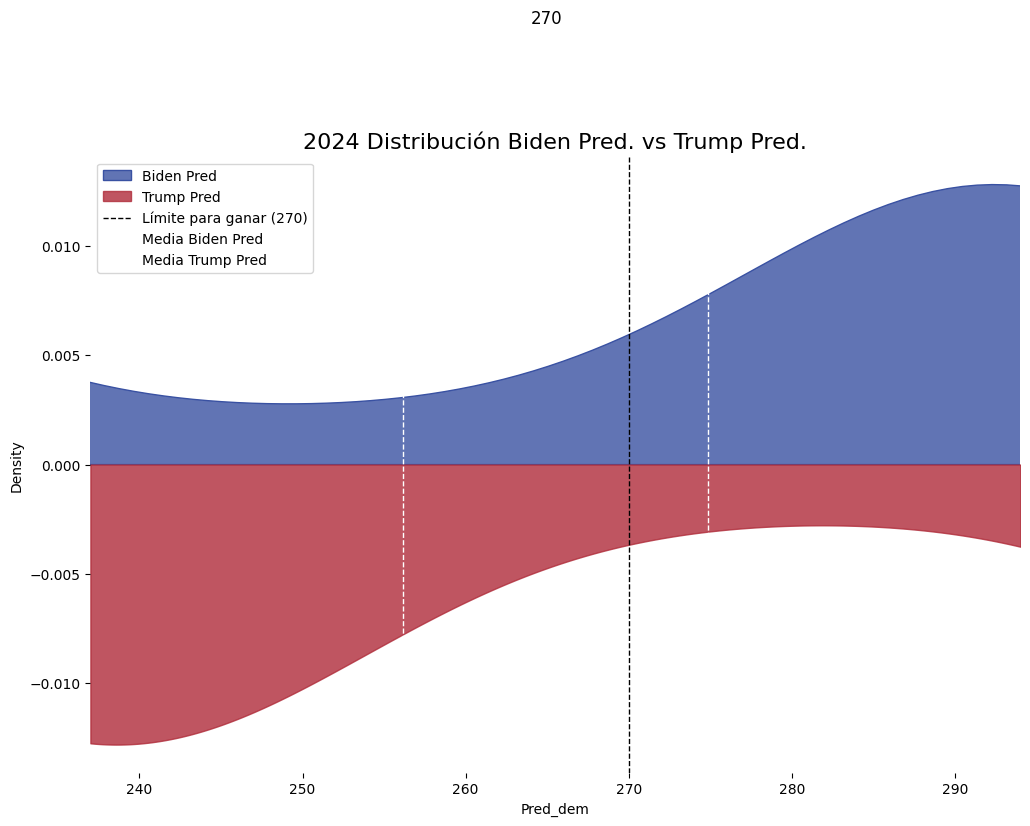

In [180]:
# Asegurarse de que los valores de Trump_Pred y Biden_Pred sean numéricos
simulation_results['Pred_gop'] = pd.to_numeric(simulation_results['Pred_gop'], errors='coerce')
simulation_results['Pred_dem'] = pd.to_numeric(simulation_results['Pred_dem'], errors='coerce')

# Eliminar cualquier fila con valores NaN (si es necesario)
simulation_results = simulation_results.dropna(subset=['Pred_gop', 'Pred_dem'])

# Crear un gráfico de densidad para las predicciones de Biden y Trump
plt.figure(figsize=(12, 8))

# Gráfico de densidad para Biden (positivo)
sns.kdeplot(simulation_results['Pred_dem'], color="#3951a2", fill=True, alpha=0.8, label="Biden Pred")

# Crear la densidad para Trump usando gaussian_kde
density_trump = gaussian_kde(simulation_results['Pred_gop'])
x_vals = np.linspace(min(simulation_results['Pred_gop']), max(simulation_results['Pred_dem']), 1000)
y_vals = density_trump(x_vals)

# Graficar la densidad de Trump invertida
plt.fill_between(x_vals, -y_vals, color="#af2b39", alpha=0.8, label="Trump Pred")

# Línea vertical en 270 votos
plt.axvline(x=270, color="black", linestyle="--", linewidth=1, label="Límite para ganar (270)")
plt.text(270-6, 0.02, '270', color="black", verticalalignment='bottom', fontsize=12)  # Añadir el valor '270' dentro del gráfico

# Línea vertical para la media de las predicciones de Biden
plt.axvline(x=np.mean(simulation_results['Pred_dem']), color="white", linestyle="--", linewidth=1, label="Media Biden Pred")
mean_biden = np.mean(simulation_results['Pred_dem'])
plt.text(mean_biden + 1, 0.01, f'{mean_biden:.0f}', color="white", verticalalignment='bottom', fontsize=12)  # Añadir el valor de la media de Biden

# Línea vertical para la media de las predicciones de Trump
plt.axvline(x=np.mean(simulation_results['Pred_gop']), color="white", linestyle="--", linewidth=1, label="Media Trump Pred")
mean_trump = np.mean(simulation_results['Pred_gop'])
plt.text(mean_trump + 1, -0.01, f'{mean_trump:.0f}', color="white", verticalalignment='top', fontsize=12)  # Añadir el valor de la media de Trump

# Ajustar el eje Y para que sea simétrico
plt.ylim(-1.1 * max(y_vals), 1.1 * max(y_vals))

# Ajustar el eje X para ver más a la izquierda
plt.xlim(min(simulation_results['Pred_gop']), max(simulation_results['Pred_dem']))

# Añadir título
plt.title(f"{ELECTORAL_YEAR} Distribución Biden Pred. vs Trump Pred.", fontsize=16)

# Añadir leyenda
plt.legend()

# Eliminar el fondo del gráfico
plt.gca().patch.set_alpha(0)  # Fondo del área del gráfico transparente

# Eliminar los bordes y la línea negra alrededor del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Guardar el gráfico como PNG con fondo transparente
plt.savefig(f"imgs/densidad_biden_trump_transparente_{ELECTORAL_YEAR}.png", format="png", transparent=True)

# Mostrar el gráfico
plt.show()

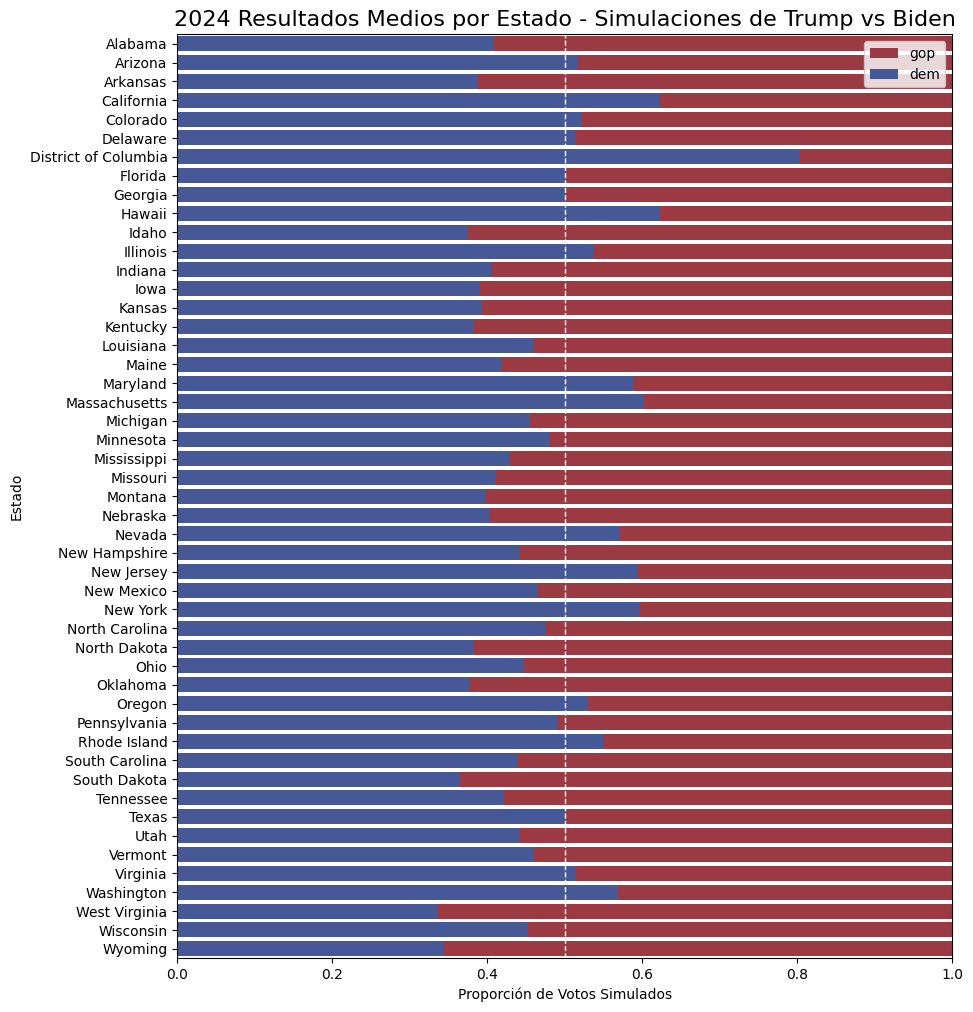

In [181]:
# Ordenar los estados por orden alfabético
accumulated_pred_state_sorted = accumulated_pred_state.sort_values('state', ascending=False)

# Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 12))

# Primero, graficar la barra de Trump
sns.barplot(x=accumulated_pred_state_sorted["Per_dem"] + accumulated_pred_state_sorted["Per_gop"], 
            y='state', data=accumulated_pred_state_sorted, color="#ac2a37", label="gop")

# Luego, graficar la barra de Biden encima de Trump
sns.barplot(x="Per_dem", y='state', data=accumulated_pred_state_sorted, color="#3951a2", label="dem")

# Añadir una línea vertical en el 50%
plt.axvline(x=0.50, color="white", linestyle="--", linewidth=1)

# Añadir leyenda
plt.legend(loc='best')

# Invertir el eje Y para que los estados se vean de arriba hacia abajo
plt.gca().invert_yaxis()

# Añadir etiquetas y título
plt.title(f'{ELECTORAL_YEAR} Resultados Medios por Estado - Simulaciones de Trump vs Biden', fontsize=16)
plt.xlabel('Proporción de Votos Simulados')
plt.ylabel('Estado')

# Ajustar el eje X para que las barras lleguen al 100%
plt.xlim(0, 1)

# Guardar el gráfico como PNG con fondo transparente
plt.savefig("imgs/porc_estado_transparente_{ELECTORAL_YEAR}.png", format="png", transparent=True)

# Mostrar el gráfico
plt.show()

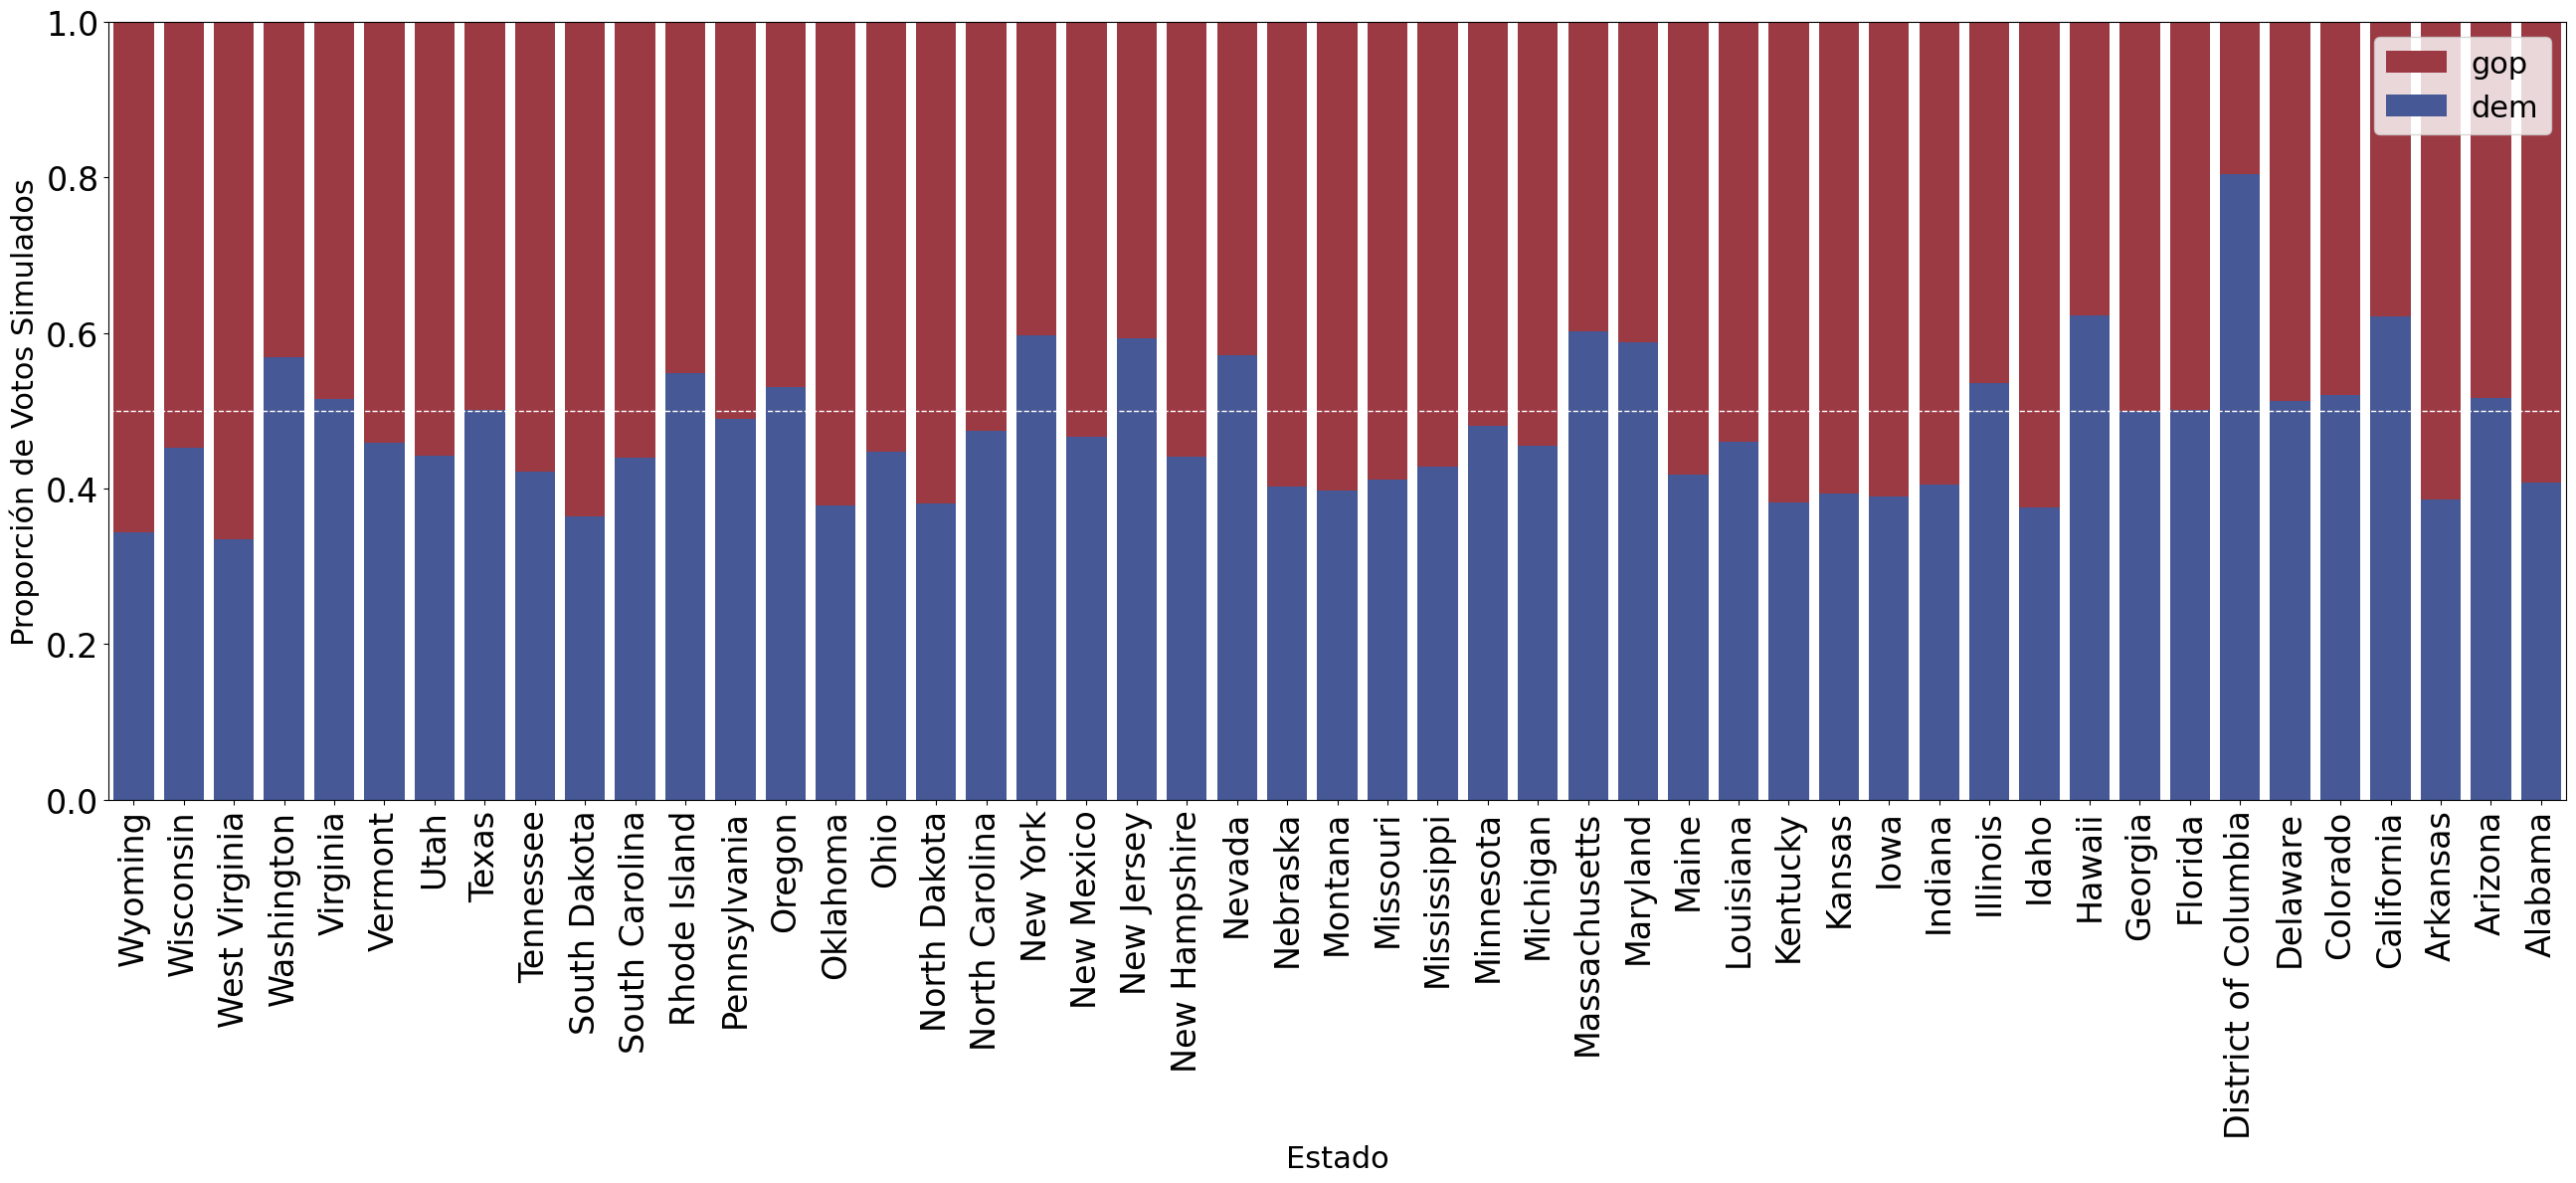

In [182]:
plt.figure(figsize=(26, 12))

# Graficar la barra de Trump (en la parte inferior)
sns.barplot(y=accumulated_pred_state_sorted["Per_dem"] + accumulated_pred_state_sorted["Per_gop"], 
            x='state', data=accumulated_pred_state_sorted, color="#ac2a37", label="gop")

# Graficar la barra de Biden encima de Trump
sns.barplot(y="Per_dem", x='state', data=accumulated_pred_state_sorted, color="#3951a2", label="dem")

# Añadir una línea horizontal en el 50%
plt.axhline(y=0.50, color="white", linestyle="--", linewidth=1)

# Añadir leyenda
plt.legend(loc='best', fontsize=22)

# Añadir etiquetas y título
# plt.title('Resultados Medios por Estado - Simulaciones de Trump vs Biden', fontsize=16)
plt.ylabel('Proporción de Votos Simulados', fontsize=22)
plt.xlabel('Estado', fontsize=22)

# Ajustar el eje Y para que las barras lleguen al 100%
plt.ylim(0, 1)

# Rotar los nombres de los estados para mejor visibilidad y aumentar el tamaño de las etiquetas
plt.xticks(rotation=90, fontsize=24)
plt.yticks(fontsize=24)

# Ajustar los márgenes del gráfico para evitar que los xticks se corten
plt.tight_layout()


# Guardar el gráfico como PNG con fondo transparente
plt.savefig(f"imgs/porc_estado_inv_transparente_{ELECTORAL_YEAR}.png", format="png", transparent=True)

# Mostrar el gráfico
plt.show()

In [183]:
# Crear el mapa coroplético usando Plotly Express con códigos de estado
fig = px.choropleth(accumulated_pred_state,
                    locations='state_code',  # Usar la nueva columna con códigos de estado
                    locationmode="USA-states",  # Modo de localización para los códigos de estado
                    color='Winner',  # Métrica que deseas visualizar
                    hover_name='state_code',  # Mostrar el código del estado en hover
                    hover_data={
                        'state_code': True,  # Mostrar el código del estado
                        "Per_dem": ':.2%',  # Mostrar el porcentaje de Biden en formato de porcentaje
                        "Per_gop": ':.2%'  # Mostrar el porcentaje de Trump en formato de porcentaje
                    },
                    scope='usa',  # Limitar el mapa a EE.UU.
                    color_discrete_map={'dem': '#3951a2', 'gop': '#af2b39'},  # Colores asignados
                    labels={f'Winner': 'Ganador {ELECTORAL_YEAR}'},  # Etiqueta para la barra de color
                    title=f"Resultado Medio de las Simulaciones - Elecciones Presidenciales {ELECTORAL_YEAR}"
                   )

# # Crear un nuevo rastro para añadir los códigos de los estados en el mapa
# fig.add_trace(go.Scattergeo(
#     locationmode='USA-states',
#     locations=accumulated_pred_state['state_code'],  # Usar los códigos de los estados
#     text=accumulated_pred_state['state_code'],  # Mostrar los códigos dentro del mapa
#     mode='text',  # Solo texto
#     textfont=dict(size=12, color="black"),  # Tamaño y color de la fuente
# ))

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar visualización y mostrar el gráfico
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa a las ubicaciones
fig.show()


In [184]:
# Crear el mapa coroplético usando Plotly Express con códigos de estado
fig = px.choropleth(accumulated_pred_state,
                    locations='state_code',  # Usar la nueva columna con códigos de estado
                    locationmode="USA-states",  # Modo de localización para los códigos de estado
                    color='Status',  # Métrica que deseas visualizar
                    hover_name='state_code',  # Mostrar el código del estado en hover
                    hover_data={
                        'state_code': True,  # Mostrar el código del estado
                        "Per_dem": ':.2%',  # Mostrar el porcentaje de Biden en formato de porcentaje
                        "Per_gop": ':.2%'  # Mostrar el porcentaje de Trump en formato de porcentaje
                    },
                    scope='usa',  # Limitar el mapa a EE.UU.
                    color_discrete_map={'Safe Democrat': '#3951a2', 
                                        'Likely Democrat': '#a3cef1', 
                                        'Toss-Up': '#b6b164', 
                                        'Likely Republican': '#d56062', 
                                        'Safe Republican': '#af2b39'},
                    labels={f'Winner': 'Ganador {ELECTORAL_YEAR}'},  # Etiqueta para la barra de color
                    title=f"Status de los Estados en las Simulaciones - Elecciones Presidenciales {ELECTORAL_YEAR}"
                   )

# # Crear un nuevo rastro para añadir los códigos de los estados en el mapa
# fig.add_trace(go.Scattergeo(
#     locationmode='USA-states',
#     locations=accumulated_pred_state['state_code'],  # Usar los códigos de los estados
#     text=accumulated_pred_state['state_code'],  # Mostrar los códigos dentro del mapa
#     mode='text',  # Solo texto
#     textfont=dict(size=12, color="black"),  # Tamaño y color de la fuente
# ))

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar visualización y mostrar el gráfico
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa a las ubicaciones
fig.show()


### Real

In [185]:
# Crear el mapa coroplético usando Plotly Express con códigos de estado
fig = px.choropleth(full_df_actual_state,
                    locations='state_code',  # Usar la nueva columna con códigos de estado
                    locationmode="USA-states",  # Modo de localización para los códigos de estado
                    color="Winner",  # Métrica que deseas visualizar
                    hover_name='state_code',  # Mostrar el código del estado en hover
                    hover_data={
                        'state_code': True,  # Mostrar el código del estado
                        "Per_dem": ':.2%',  # Mostrar el porcentaje de Biden en formato de porcentaje
                        "Per_gop": ':.2%'  # Mostrar el porcentaje de Trump en formato de porcentaje
                    },
                    scope='usa',  # Limitar el mapa a EE.UU.
                    color_discrete_map={'dem': '#3951a2', 'gop': '#af2b39'},  # Colores asignados
                    labels={"Winner": 'Ganador {ELECTORAL_YEAR}'},  # Etiqueta para la barra de color
                    title=f"Resultado Real de las Simulaciones - Elecciones Presidenciales {ELECTORAL_YEAR}"
                   )

# # Crear un nuevo rastro para añadir los códigos de los estados en el mapa
# fig.add_trace(go.Scattergeo(
#     locationmode='USA-states',
#     locations=accumulated_pred_state['state_code'],  # Usar los códigos de los estados
#     text=accumulated_pred_state['state_code'],  # Mostrar los códigos dentro del mapa
#     mode='text',  # Solo texto
#     textfont=dict(size=8, color="white"),  # Tamaño y color de la fuente
# ))

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)

# Ajustar visualización y mostrar el gráfico
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa a las ubicaciones
fig.show()


In [186]:
# Crear el mapa coroplético usando Plotly Express con códigos de estado
fig = px.choropleth(full_df_actual_state,
                    locations='state_code',  # Usar la nueva columna con códigos de estado
                    locationmode="USA-states",  # Modo de localización para los códigos de estado
                    color='Status',  # Métrica que deseas visualizar
                    hover_name='state_code',  # Mostrar el código del estado en hover
                    hover_data={
                        'state_code': True,  # Mostrar el código del estado
                        'Per_dem': ':.2%',  # Mostrar el porcentaje de Biden en formato de porcentaje
                        'Per_gop': ':.2%'  # Mostrar el porcentaje de Trump en formato de porcentaje
                    },
                    scope='usa',  # Limitar el mapa a EE.UU.
                    color_discrete_map={'Safe Democrat': '#3951a2', 
                                        'Likely Democrat': '#a3cef1', 
                                        'Toss-Up': '#b6b164', 
                                        'Likely Republican': '#d56062', 
                                        'Safe Republican': '#af2b39'},
                    labels={"Winner": 'Ganador {ELECTORAL_YEAR}'},  # Etiqueta para la barra de color
                    title=f"Status de los Estados en las Simulaciones - Elecciones Presidenciales {ELECTORAL_YEAR}"
                   )

# # Crear un nuevo rastro para añadir los códigos de los estados en el mapa
# fig.add_trace(go.Scattergeo(
#     locationmode='USA-states',
#     locations=accumulated_pred_state['state_code'],  # Usar los códigos de los estados
#     text=accumulated_pred_state['state_code'],  # Mostrar los códigos dentro del mapa
#     mode='text',  # Solo texto
#     textfont=dict(size=12, color="black"),  # Tamaño y color de la fuente
# ))

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=1200,  # Ajustar el ancho del gráfico
    height=800   # Ajustar la altura del gráfico
)



# Ajustar visualización y mostrar el gráfico
fig.update_geos(fitbounds="locations", visible=False)  # Ajustar el mapa a las ubicaciones
fig.show()
